In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch
import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
# # automatic feature selection, based on feature importance notebook

# df_feat_sel = pd.read_csv(params.feat_sel_csv, index_col=0, parse_dates=True)
# df_feat_sel

In [4]:
# alternative manual feature selection, based on the features selected in the params.py

df_feat_all = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)
df_feat_sel = df_feat_all[params.features_cols_tick + ['bid','ask'] + [params.label_col]] # manual alternative
df_feat_sel

In [5]:
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y_sig     =", y_sig.shape, "(samples,)")
print("  y_ret     =", y_ret.shape, "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)
print("  end_times =", end_times.shape)


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2412342, 60, 4]) (samples, look_back, features)
  y_sig     = torch.Size([2412342]) (samples,)
  y_ret     = torch.Size([2412342]) (samples,)
  raw_close = torch.Size([2412342])
  raw_bid   = torch.Size([2412342])
  raw_ask   = torch.Size([2412342])
  end_times = (2412342,)


In [6]:
# Split into train/val/test by calendar day
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_sig_tr, y_ret_tr =", y_sig_tr.shape, y_ret_tr.shape)
print("  X_val =", X_val.shape)
print("  y_sig_val, y_ret_val =", y_sig_val.shape, y_ret_val.shape)
print("  X_te  =", X_te.shape)
print("  y_sig_te, y_ret_te =", y_sig_te.shape, y_ret_te.shape)


Shapes:
  X_tr  = torch.Size([1694522, 60, 4])
  y_sig_tr, y_ret_tr = torch.Size([1694522]) torch.Size([1694522])
  X_val = torch.Size([353129, 60, 4])
  y_sig_val, y_ret_val = torch.Size([353129]) torch.Size([353129])
  X_te  = torch.Size([364691, 60, 4])
  y_sig_te, y_ret_te = torch.Size([364691]) torch.Size([364691])


In [7]:
# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

print(f"Days  → train={len(train_loader.dataset)}, val={len(val_loader.dataset)}, test={len(test_loader.dataset)}")
print(f"Batches → train={len(train_loader)},   val={len(val_loader)},   test={len(test_loader)}")

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days  → train=3808, val=783, test=809
Batches → train=119,   val=783,   test=809


In [8]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = X.shape[-1],                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(params.device)  

model

DualMemoryLSTM(
  (conv): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(4, 48, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (do_short): Dropout(p=0.25, inplace=False)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(96, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.3, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (cls_ter): Linear(in_features=128, out_features=3, bias=True)
)

In [9]:
# -----------------------------------------------------------------------------
# Compute plateau_sched timing parameters
# -----------------------------------------------------------------------------
# Total training samples = total windows in X_tr (one window per row)
n_train_samples = X_tr.shape[0]

# How many optimizer steps (day‐bundles) constitute one epoch?
steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 5e-05
    lr: 5e-05
    maximize: False
    weight_decay: 0.001
)

In [10]:
# -----------------------------------------------------------------------------
# Count how many calendar days we see each epoch and Compute baseline RMSE on validation (zero forecast)
# -----------------------------------------------------------------------------
n_train_days = len(train_loader.dataset)  # dataset length = # unique days
print(f"Training sees {n_train_days} calendar days per epoch\n")

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"Baseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")

Training sees 3808 calendar days per epoch

Baseline (zero‐forecast) RMSE on validation = 0.414885


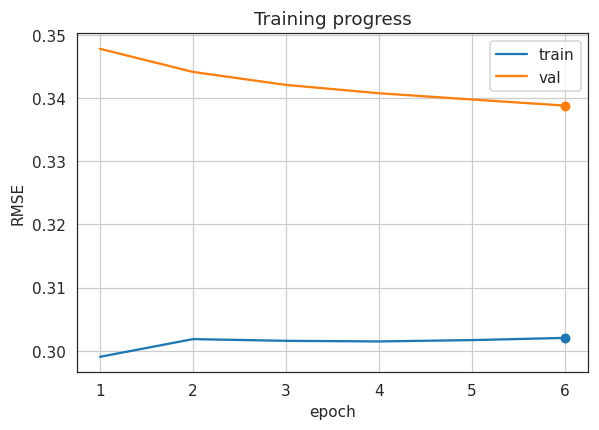

Epoch 1:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2990 MAE=0.2213 R2=-0.0909 | "B": Acc=0.6842 Prec=0.3752 Rec=0.1753 F1=0.2389 AUROC=0.5971
VALID→ "R": RMSE=0.3478 MAE=0.2363 R2=-0.5937 | "B": Acc=0.7246 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.5441


Epoch 2:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.3018 MAE=0.2180 R2=-0.1114 | "B": Acc=0.7155 Prec=0.3696 Rec=0.0085 F1=0.0165 AUROC=0.4625
VALID→ "R": RMSE=0.3441 MAE=0.2333 R2=-0.5603 | "B": Acc=0.7246 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.5485


Epoch 3:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.3016 MAE=0.2173 R2=-0.1094 | "B": Acc=0.7160 Prec=0.3801 Rec=0.0068 F1=0.0133 AUROC=0.4589
VALID→ "R": RMSE=0.3421 MAE=0.2316 R2=-0.5417 | "B": Acc=0.7246 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.5517


Epoch 4:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.3015 MAE=0.2169 R2=-0.1087 | "B": Acc=0.7161 Prec=0.3813 Rec=0.0063 F1=0.0124 AUROC=0.4615
VALID→ "R": RMSE=0.3408 MAE=0.2306 R2=-0.5298 | "B": Acc=0.7246 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.5534


Epoch 5:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.3017 MAE=0.2166 R2=-0.1103 | "B": Acc=0.7161 Prec=0.3794 Rec=0.0060 F1=0.0117 AUROC=0.4666
VALID→ "R": RMSE=0.3398 MAE=0.2298 R2=-0.5209 | "B": Acc=0.7246 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.5535


Epoch 6:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.3020 MAE=0.2165 R2=-0.1128 | "B": Acc=0.7163 Prec=0.3934 Rec=0.0056 F1=0.0111 AUROC=0.4728
VALID→ "R": RMSE=0.3388 MAE=0.2291 R2=-0.5123 | "B": Acc=0.7246 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.5549


Epoch 7:   0%|          | 0/119 [00:00<?, ?batch/s]

In [ ]:
# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    baseline_val_rmse   = baseline_val_rmse,
    clipnorm            = clipnorm,
    device              = params.device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement = 100.0 * (1.0 - best_val_rmse / baseline_val_rmse)
print(f"Improvement over zero‐baseline = {improvement:5.1f}%")
